In [47]:
%reset -sf

import matplotlib.pyplot as plt
import numpy as np
from flow import *
from utils import *
import get_data as gd
import gc

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Load data

In [48]:
processor = gd.DataProcessor()
path = "/root/work/truth/signal/*npz"
processor.load_files(path)

CGLMP, Higgs, LeadLep, LepM, LepP, NuM, NuP, MET, Wm, Wp, diLep, SubLep, Xi = processor.files


# observed (Y)
MET_kin = processor.process_MET(MET).iloc[:, 1:3]
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(5), end="\n")

# interest (X)
dinu_kin = processor.process_dinu(NuP, NuM)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(5), end="\n")


del processor  # Clear the instance
del CGLMP, Higgs, LeadLep, LepM, LepP, NuM, NuP, MET, Wm, Wp, diLep, SubLep, Xi # Clear the dataframes
gc.collect()

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']
MET_kin shape: (2928862, 2)
     di_nu_px   di_nu_py
0   21.531590  58.661363
1  142.831582 -36.235636
2   -4.344014 -53.593527
3  -19.836591 -17.248187
4  -21.864079 -26.724745
dinu_kin shape: (2928862, 4)
         nu_E       nu_px      nu_py       nu_pz
0  122.129977   21.531590  58.661363   93.688699
1  611.032109  142.831582 -36.235636  592.323953
2   74.715202   -4.118662 -52.749777   44.663706
3   41.097882  -19.836591 -17.248187   12.641004
4  154.431047  -21.864079 -26.724745  149.285

4099

Preprocessing

In [49]:
# normalize
from sklearn.preprocessing import StandardScaler
SCALAR = StandardScaler()
var = np.concatenate([dinu_kin, MET_kin], axis=-1)
norm_var = SCALAR.fit_transform(var)
dinu_kin, MET_kin = norm_var[:, 0:4], norm_var[:, 4:6]

In [50]:
from sklearn.model_selection import train_test_split

indices_arr = np.arange(dinu_kin.shape[0], dtype='int')
indices_arr = np.random.choice(indices_arr, int(1e4))
train_indices, test_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)

train_x = dinu_kin[train_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}."
)
print()
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (8000, 4);
Testing data shape: (2000, 4).

Y (Observed)
Training data shape: (8000, 2);
Testing data shape: (2000, 2).


Setup

In [51]:
# interest (momentum)
# x_dim = 2*4 + 4
x_dim = 4
# observed (MET)
# y_dim = 2*4 + 2
y_dim = 2
z_dim =  4

tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim

# Preprocess
## Pad data
X = train_x.reshape((-1, x_dim))
# print("pad_dim", pad_dim)
pad_x = np.zeros((X.shape[0], pad_dim))
# print("pad_x", pad_x.shape)
x = np.concatenate([X, pad_x], axis=-1).astype("float32")
print("x", x.shape)
z = np.random.multivariate_normal([0.]*z_dim, np.eye(z_dim), X.shape[0]).astype("float32")
y_hat = train_y.reshape(-1, y_dim)
print("y", y_hat.shape)
print("z", z.shape)
y = np.concatenate([z, y_hat], axis=-1).astype("float32")

print(f"Input dataset shape: {x.shape}, {y.shape}")
n_sample = X.shape[0]
n_data = n_sample * train_y.flatten().shape[0]
n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 128

n_batch = 1024
n_epoch = 64
n_display = n_batch

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x)
y_data = tf.data.Dataset.from_tensor_slices(y)
dataset = (tf.data.Dataset.zip((x_data, y_data))
           .shuffle(buffer_size=X.shape[0])
           .batch(n_batch, drop_remainder=True)
           .repeat())

x (8000, 6)
y (8000, 2)
z (8000, 4)
Input dataset shape: (8000, 6), (8000, 6)


Initialize the model

In [52]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name="NVP")
x = tfk.Input((tot_dim,))
model(x)
model.summary()

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLaye  multiple                  134674    
 rs)                                                             
                                                                 
 Layer1 (TwoNVPCouplingLaye  multiple                  134674    
 rs)                                                             
                                                                 
 Layer2 (TwoNVPCouplingLaye  multiple                  134674    
 rs)                                                             
                                                                 
 Layer3 (TwoNVPCouplingLaye  multiple                  134674    
 rs)                                                             
                                                                 
 Layer4 (TwoNVPCouplingLaye  multiple                  134674  

In [53]:
class Trainer(tfk.Model):
    def __init__(self, model, x_dim, y_dim, z_dim, tot_dim, 
                 n_couple_layer, n_hid_layer, n_hid_dim, shuffle_type="reverse"):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.
        self.w2 = 1.
        self.w3 = 10.
        self.loss_factor = 1.
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data): 
        x_data, y_data = data
        x = x_data[:, :self.x_dim]
        y = y_data[:, -self.y_dim:]
        z = y_data[:, :self.z_dim]
        # print("x", x.shape)
        # print("y", y.shape)
        # print("z", z.shape)
        # print("x_data", x_data.shape)
        y_short = tf.concat([z, y], axis=-1)
        # print("y_short", y_short.shape)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)    
            pred_loss = self.w1 * self.loss_fit(y_data[:,self.z_dim:], y_out[:,self.z_dim:]) # [zeros, y] <=> [zeros, yhat]
            # print(y_out)
            # print("!!!!!!!")
            # print("z_dim", z_dim)
            # print("y_dim", y_dim)
            # print(y_out[:, :self.z_dim])
            # print(y_out[:, -self.y_dim:])
            output_block_grad = tf.concat([y_out[:, :self.z_dim], y_out[:, -self.y_dim:]], axis=-1) # take out [z, y] only (not zeros)
            # print("y_out", y_short)
            # print("output", output_block_grad)
            latent_loss = self.w2 * self.loss_latent(y_short, output_block_grad) # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
            # print(latent_loss)
            # print(forward_loss)
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            #rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_backward, self.model.trainable_weights)) 

        total_loss = forward_loss + latent_loss + rev_loss
        return {"total_loss": total_loss,
                "forward_loss": forward_loss,
                "latent_loss": latent_loss,
                "rev_loss": rev_loss}

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [54]:
trainer = Trainer(model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim)
trainer.compile(optimizer="Adam")

Training

In [55]:
LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)
hist = trainer.fit(dataset,
                   batch_size=n_batch,
                   epochs=n_epoch,
                   steps_per_epoch=n_data//n_batch,
                   callbacks=[logger, LossFactor],
                   verbose=1)

=== Started at 2023-11-09 06h:40m:09s ===
Epoch 1/32


  3357/250000 [..............................] - ETA: 2:52:49 - total_loss: 0.4661 - forward_loss: 0.2998 - latent_loss: 0.0238 - rev_loss: 0.1425

KeyboardInterrupt: 

Results

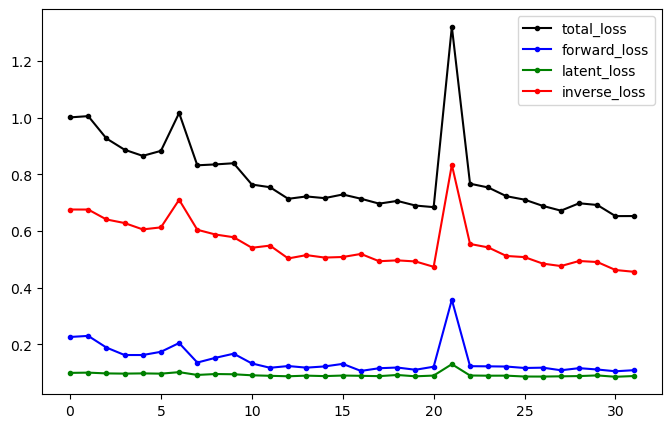

In [ ]:
fig, ax = plt.subplots(1, facecolor="white", figsize=(8,5))
ax.plot(hist.history["total_loss"], "k.-", label="total_loss")
ax.plot(hist.history["forward_loss"], "b.-", label="forward_loss")
ax.plot(hist.history["latent_loss"], "g.-", label="latent_loss")
ax.plot(hist.history["rev_loss"], "r.-", label="inverse_loss")
plt.legend()
plt.savefig("loss.png")
plt.show()
plt.close()

In [ ]:
# Preprocess

y_hat = test_y.reshape(-1, y_dim)
z = np.random.multivariate_normal([1.]*z_dim, np.eye(z_dim), y_hat.shape[0])
y = np.concatenate([z, y_hat], axis=-1).astype("float32")
x_pred = model.inverse(y).numpy()
pz_pred = x_pred[:, 3]
E_pred = x_pred[:, 0]
x_truth = test_x.reshape(-1, x_dim)
pz_truth = x_truth[:, 3]
E_truth = x_truth[:, 0]

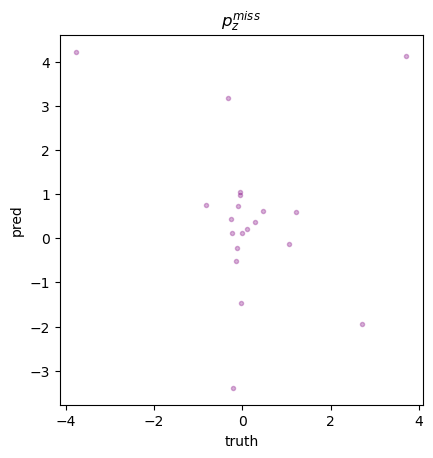

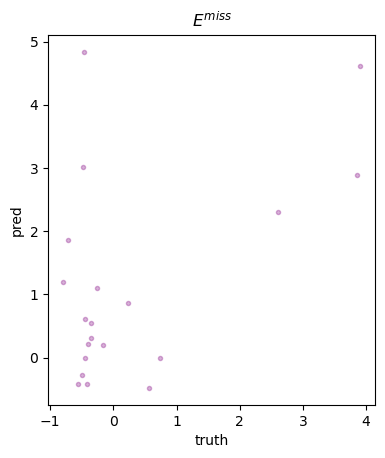

In [ ]:
# plot_2d_histogram(pz_pred, pz_truth, r"$p^{miss}_{z}$")
plt.plot(pz_truth, pz_pred, ".", alpha=.3, color="purple")
plt.title(r"$p^{miss}_{z}$")
plt.xlabel("truth")
plt.ylabel("pred")
plt.gca().set_aspect('equal')
plt.savefig("pz.png")
plt.show()
plt.close()

plt.plot(E_truth, E_pred, ".", alpha=.3, color="purple")
plt.title(r"$E^{miss}$")
plt.xlabel("truth")
plt.ylabel("pred")
plt.gca().set_aspect('equal')
plt.savefig("energy.png")
plt.show()
plt.close()